In [1]:
import tensorflow as tf
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "1"
config = tf.ConfigProto()
config.gpu_options.allow_growth = True
#config.gpu_options.per_process_gpu_memory_fraction = 0.3
#set_session(tf.Session(config=config))
session = tf.Session(config=config)

/home/student1/anaconda3/envs/keras/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


## 如何画ROC曲线以及计算AUC

关于ROC和AUC的简单介绍请看 [ROC和AUC介绍以及如何计算AUC](http://alexkong.net/2013/06/introduction-to-auc-and-roc/)
如何在Keras中计算请看 [How to compute Receiving Operating Characteristic (ROC) and AUC in keras?](https://stackoverflow.com/questions/41032551/how-to-compute-receiving-operating-characteristic-roc-and-auc-in-keras)

当然，只看看是不行的，我们要动手实验实验，下面，我将用建立二元分类网络，用来判断cifar10图片是否是第三类

In [2]:
from keras.datasets import cifar10
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, BatchNormalization, Dropout

from sklearn.metrics import roc_curve, roc_auc_score

import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

Using TensorFlow backend.


In [3]:
target_num = 3
# 导入数据
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

# 将数据分成两部分：偶数 奇数
train_indices = np.where(y_train ==3)
test_indeices = np.where(y_test == 3)

# 二元分类问题，label为0或者1
new_y_train = np.zeros_like(y_train, dtype='float32')
new_y_test = np.zeros_like(y_test, dtype='float32')
new_y_train[train_indices] = 1.0
new_y_test[test_indeices] = 1.0
del y_train
del y_test

# 预处理
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255.
x_test /= 255.
#x_train = np.expand_dims(x_train, axis=3)
#x_test = np.expand_dims(x_test, axis=3)


print('x train shape:{}, y train shape:{}'.format(x_train.shape, new_y_train.shape))
print('x test shape:{}, y test shape:{}'.format(x_test.shape, new_y_test.shape))

x train shape:(50000, 32, 32, 3), y train shape:(50000, 1)
x test shape:(10000, 32, 32, 3), y test shape:(10000, 1)


In [4]:
batch_size = 64
epochs = 10

In [12]:
# 建立模型
# 先建立一个简单模型
simple_model = Sequential()
simple_model.add(Conv2D(4, (3,3), strides=(2,2), activation='relu', input_shape=(32, 32, 3)))
simple_model.add(Flatten())
simple_model.add(Dense(8, activation='relu'))
simple_model.add(Dense(1, activation='sigmoid'))

simple_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])

In [13]:
# 简单模型的训练
history = simple_model.fit(x_train, new_y_train, batch_size=batch_size, epochs=epochs, validation_split=0.2)

Train on 40000 samples, validate on 10000 samples
Epoch 1/10
40000/40000 [==============================] - 3s 76us/step - loss: 0.3071 - acc: 0.9003 - val_loss: 0.2945 - val_acc: 0.8984
Epoch 2/10
40000/40000 [==============================] - 3s 72us/step - loss: 0.2884 - acc: 0.9004 - val_loss: 0.2894 - val_acc: 0.8984
Epoch 3/10
40000/40000 [==============================] - 3s 72us/step - loss: 0.2818 - acc: 0.9004 - val_loss: 0.2836 - val_acc: 0.8984
Epoch 4/10
40000/40000 [==============================] - 3s 71us/step - loss: 0.2773 - acc: 0.9004 - val_loss: 0.2802 - val_acc: 0.8984
Epoch 5/10
40000/40000 [==============================] - 3s 71us/step - loss: 0.2727 - acc: 0.9005 - val_loss: 0.2756 - val_acc: 0.8990
Epoch 6/10
40000/40000 [==============================] - 3s 72us/step - loss: 0.2684 - acc: 0.9005 - val_loss: 0.2727 - val_acc: 0.8989
Epoch 7/10
40000/40000 [==============================] - 3s 71us/step - loss: 0.2629 - acc: 0.9004 - val_loss: 0.2766 - val_acc

In [14]:
# auc
simple_prediction = simple_model.predict(x_test)
simple_auc = roc_auc_score(new_y_test,simple_prediction)
print('AUC is {}'.format(simple_auc))
# ROC曲线 
s_fpr, s_tpr, s_t = roc_curve(new_y_test, simple_prediction)

AUC is 0.8081179444444444


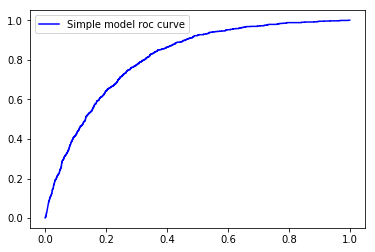

In [15]:
# plot roc curve
plt.plot(s_fpr, s_tpr, 'b', label='Simple model roc curve')
plt.legend()
plt.show()

In [6]:
# 复杂一点的模型
model = Sequential()
model.add(Conv2D(64, (3,3), activation='relu', input_shape=(32, 32, 3)))
model.add(Conv2D(64, (3,3), activation='relu'))
model.add(MaxPooling2D())
model.add(Dropout(0.5))
model.add(Conv2D(128, (3,3), activation='relu'))
model.add(Conv2D(128, (3,3), activation='relu'))
model.add(MaxPooling2D())
model.add(Dropout(0.5))
model.add(Conv2D(256, (3,3), activation='relu'))
model.add(Conv2D(256, (3,3), activation='relu'))
model.add(Dropout(0.5))

model.add(Flatten())
model.add(BatchNormalization())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])

In [7]:
model.fit(x_train, new_y_train, batch_size=batch_size, epochs=epochs, validation_split=0.2)

Train on 40000 samples, validate on 10000 samples
Epoch 1/10
40000/40000 [==============================] - 16s 394us/step - loss: 0.3174 - acc: 0.8963 - val_loss: 0.4658 - val_acc: 0.8984
Epoch 2/10
40000/40000 [==============================] - 14s 361us/step - loss: 0.2840 - acc: 0.9004 - val_loss: 0.2701 - val_acc: 0.8984
Epoch 3/10
40000/40000 [==============================] - 14s 360us/step - loss: 0.2745 - acc: 0.9004 - val_loss: 0.2871 - val_acc: 0.8984
Epoch 4/10
40000/40000 [==============================] - 14s 360us/step - loss: 0.2695 - acc: 0.9004 - val_loss: 0.2701 - val_acc: 0.8984
Epoch 5/10
40000/40000 [==============================] - 14s 361us/step - loss: 0.2662 - acc: 0.9004 - val_loss: 0.2630 - val_acc: 0.8984
Epoch 6/10
40000/40000 [==============================] - 14s 359us/step - loss: 0.2583 - acc: 0.9003 - val_loss: 0.2963 - val_acc: 0.8984
Epoch 7/10
40000/40000 [==============================] - 14s 360us/step - loss: 0.2535 - acc: 0.9004 - val_loss: 0.

In [10]:
# auc
prediction = model.predict(x_test)
auc = roc_auc_score(new_y_test,prediction)
print('AUC is {}'.format(auc))
# ROC曲线 
fpr, tpr, t = roc_curve(new_y_test, prediction)

AUC is 0.8575873333333334


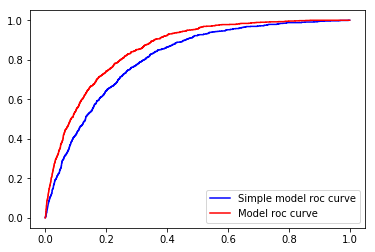

In [16]:
# plot roc curve
plt.plot(s_fpr, s_tpr, 'b', label='Simple model roc curve')
plt.plot(fpr, tpr, 'r', label='Model roc curve')

plt.legend()
plt.show()
# 就下图而言，复杂模型效果好一些

## 总结
计算AUC和ROC的步骤为

1. 计算模型在测试集上的prediction
2. 调包啊！使用sklearn的roc_curve， roc_auc_score等等
3. 画出曲线

嗯，调包果然很简单！